# Analysing Word Embeddings

Author of this notebook: Benedikt Peterseim

##### Some necessary imports:

In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('wordnet_ic')
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.corpus import wordnet_ic
from scipy.stats import spearmanr

[nltk_data] Downloading package wordnet to /Users/puester/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/puester/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


##### Now we load two pre-trained Word Embedding models.

At the present moment, the file

GoogleNews-vectors-negative300.bin

can be obtained from https://code.google.com/archive/p/word2vec/ (see section "pre-trained word and phrase vectors").

Similarly,

glove.6B.300d.txt

can be obtained from https://nlp.stanford.edu/projects/glove/ .

In [ ]:
# Load the GoogleNews 300 Word2Vec model.
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# Also load GloVe...

glove_model = {}

with open("glove.6B.300d.txt", 'r', encoding="utf-8") as f:

    for line in f:

        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding

print(len(glove_model), " words loaded.")

400000  words loaded.


##### Some utility for handling relations in WordNet

In [ ]:
def get_list_of_words(list_of_synsets):

    set_of_words = set([])

    for synset in list_of_synsets:

        set_of_words.update(set(synset.lemma_names()))

    return list(set_of_words)


flatten_list = lambda l: [j for k in l for j in k] # We'll use this below.


def get_hyponyms(synset):

    hypos = set(synset.hyponyms())
    hypos_difference = hypos

    while hypos_difference != set():

        hypos_old = set(hypos)
        hypos = hypos.union(set(flatten_list([s.hyponyms() for s in hypos])))
        hypos = set(hypos)
        hypos_difference = hypos.difference(hypos_old)

    return list(hypos)


def get_hypernyms(synset):

    hyprs = set(synset.hypernyms())
    hyprs_difference = hyprs

    while hyprs_difference != set():

        hyprs_old = set(hyprs)
        hyprs = hyprs.union(set(flatten_list([s.hypernyms() for s in hyprs])))
        hyprs = set(hyprs)
        hyprs_difference = hyprs.difference(hyprs_old)

    return list(hyprs)



def max_path_similarity(word1, word2):

    path_similarities = [synset1.path_similarity(synset2) for synset1 in wordnet.synsets(word1) for synset2 in wordnet.synsets(word2)]
    path_similarities += [synset2.path_similarity(synset1) for synset1 in wordnet.synsets(word1) for synset2 in wordnet.synsets(word2)]
    path_similarities = [v for v in path_similarities if v != None]

    return max(path_similarities)


# Information content data, we need this to compute Lin similarity.
semcor_ic = wordnet_ic.ic('ic-semcor.dat')


def max_lin_similarity(word1, word2):
    # Lin similarity, see references in report. Lin similarity is defined between synsets,
    # to get a similarity score between words, we choose the maximum similarity between
    # the synsets for a given word.

    part_of_speech = 'n'  # we focus on nouns
    lin_similarities = [synset1.lin_similarity(synset2, semcor_ic) for synset1 in wordnet.synsets(word1, pos=part_of_speech) for synset2 in wordnet.synsets(word2, pos=part_of_speech)]
    lin_similarities += [synset2.lin_similarity(synset1, semcor_ic) for synset1 in wordnet.synsets(word1, pos=part_of_speech) for synset2 in wordnet.synsets(word2, pos=part_of_speech)]
    lin_similarities = [v for v in lin_similarities if v != None]

    if lin_similarities != []:

        return max(lin_similarities)

    else:

        return 0


def max_lch_similarity(word1, word2): # Leacock-Chodorow similarity, see references in report.

    part_of_speech = 'n'  # we focus on nouns
    lch_similarities = [synset1.lch_similarity(synset2) for synset1 in wordnet.synsets(word1, pos=part_of_speech) for synset2 in wordnet.synsets(word2, pos=part_of_speech)]
    lch_similarities += [synset2.lch_similarity(synset1) for synset1 in wordnet.synsets(word1, pos=part_of_speech) for synset2 in wordnet.synsets(word2, pos=part_of_speech)]
    lch_similarities = [v for v in lch_similarities if v != None]

    if lch_similarities != []:

        return max(lch_similarities)/3.6375861597263857  # normalize

    else:

        return 0

print(max_lch_similarity('tiger', 'leopard'), max_lch_similarity('idea', 'leopard'))  # an example

0.6979831568441128 0.27450314199189585


In [ ]:
class Subembedding:
    """ Class for sub-Word Embeddings for a list of words from WordNet.

    Attributes
    ----------
    embedding : dict
        dictonary of the form {word : word_vector}
    singular_values_
        singular values (in case PCA is performed when creating Subemdding instance)
    components_
        principal components (in case PCA is performed when creating Subemdding instance)
    n_components_
        number of principal comp. (in case PCA is performed when creating Subemdding instance)

    Methods
    -------
    words() : list
        list of words contained in the embedding
    vectors() : np.ndarray
        matrix of embedding vectors
    cos_sim(word_1, word_2)
        cosine similarity between vectors representing word_1 and word_2, respectively.
    eucl_dist(word_1, word_2)
        euclidean distance between vectors representing word_1 and word_2, respectively.
    most_similar(word_or_vector, dtype='word', similarity_measure='cosine_similarity', n_words=10)
        n_words most similar words to word_or_vector (of given dtype 'word' or 'vector')
        according to similarity_measure.
    sample_similarity(relation='random', similarity_measure='cosine_similarity', n_samples=1000)
        create a sample (of size n_samples) of the similarities (according to similarity_measure)
        of random pairs of words related by relation.
    correlate_similarity(n_samples=1000, threshold=.5)
        estimates the Spearman rank correlation coeffiecient between the different similarity
        measures, for a sample (of size n_samples) of random pairs of words which have
        similarity of at least threshold for one of the similarity measures considered.
    """

    def __init__(self, list_of_words, model=word2vec_model, apply_pca=True, estimate_dimension=False, n_comps='auto'):

        self.embedding = {}

        for word in list_of_words:

            try: self.embedding[word] = model[word]
            except KeyError: pass

        words = list(self.embedding.keys())
        vectors = np.array([self.embedding[word] for word in words])

        if len(vectors) == 0:

            vectors = np.array([[0]])

        if apply_pca == True:

            if estimate_dimension == True and len(words) >= len(vectors[0]):

                pca = PCA(n_components='mle')

            elif estimate_dimension == True and len(words) < len(vectors[0]):

                raise ValueError

            elif estimate_dimension == True and n_comps != 'auto':

                pca = PCA(n_components=n_comps)

            else:

                pca = PCA()

            pca.fit_transform(vectors)
            self.singular_values_ = pca.singular_values_
            self.components_ = pca.components_
            self.n_components_ = pca.n_components_

        self.embedding = {words[i]:vectors[i] for i in range(len(words))}


    def words(self):

        return list(self.embedding.keys())


    def vectors(self):

        return np.array([self.embedding[word] for word in self.words()])


    def cos_sim(self, word_1, word_2):
        # Cosine similarity of two words in the subembedding.

        v_1, v_2 = self.embedding[word_1], self.embedding[word_2]

        return np.dot(v_1, v_2)/(np.linalg.norm(v_1) * np.linalg.norm(v_2))


    def eucl_dist(self, word_1, word_2):
        # Euclidean distance of two words in the subembedding.

        return np.linalg.norm(self.embedding[word_1] - self.embedding[word_2])


    def most_similar(self, word_or_vector, dtype='word', similarity_measure='cosine_similarity', n_words=10):
        # Compute the n_words most similar words in the Sumbembedding to word_or_vector.

        if dtype == 'word':

            word = word_or_vector

            if similarity_measure == 'euclidean':

                sim_array = np.array([self.eucl_dist(word, other_word) for other_word in self.words()])

            elif similarity_measure == 'cosine_similarity':

                sim_array = np.array([self.cos_sim(word, other_word) for other_word in self.words()])

            indices = np.argpartition(sim_array, n_words+1)[1:n_words+1]

        elif dtype == 'vector':

            v = word_or_vector

            if similarity_measure == 'euclidean':

                sim_array = np.array([np.linalg.norm(v - self.embedding[word]) for word in self.words()])

            elif similarity_measure == 'cosine_similarity':

                sim_array = []

                for word in self.words():

                    w = self.embedding[word]
                    sim = np.dot(v, w)/(np.linalg.norm(v) * np.linalg.norm(w))
                    sim_array.insert(0, sim)

                sim_array = np.array(sim_array)

            indices = np.argpartition(sim_array, n_words)[:n_words]

        return [self.words()[i] for i in indices]


    def sample_similarity(self, relation='random', similarity_measure='cosine_similarity', n_samples=1000):
        """ Creates a sample of the similarity between two random words related by some WordNet relation.

        Parameters
        ----------
        relation : str
            can be any of the following (delault is 'random')
            - 'random': no relation -- similarity between random pairs of words
            - 'synonymity': similarity between random _non-identical_ synonyms
            - 'direct-hypernymy': similarity between random _direct_ hypernyms (parent nodes)
            - 'direct-hyponymy': similarity between random _direct_ hyponyms (child nodes)
            - 'hypernymy': similarity between random word and random choice from _all_ hyponyms (parent nodes)
            - 'hyponymy': similarity between random word and random choice from _all_ hypernyms (child nodes)

        similarity_measure : str
            one of the following
            - 'cosine_similarity': the cosine similarity (normalized dot product) between two representations of words
            - 'euclidean_distance': euclidean distance between two representations of words
        n_samples : int
            number of samples
        """

        sample_list = []
        words = self.words()
        i = 0

        if relation == 'random':

            if similarity_measure == 'cosine_similarity':

                while i < n_samples:

                    sample_list.append(self.cos_sim(random.choice(words), random.choice(words)))
                    i += 1

            elif similarity_measure == 'euclidean':

                while i < n_samples:

                    sample_list.append(self.eucl_dist(random.choice(words), random.choice(words)))
                    i += 1

            elif similarity_measure == 'path_similarity':

                while i < n_samples:

                    sample_list.append(max_path_similarity(random.choice(words), random.choice(words)))
                    i += 1

            elif similarity_measure == 'lin_similarity':

                while i < n_samples:

                    sample_list.append(max_lin_similarity(random.choice(words), random.choice(words)))
                    i += 1

            elif similarity_measure == 'lch_similarity':

                while i < n_samples:

                    sample_list.append(max_lch_similarity(random.choice(words), random.choice(words)))
                    i += 1

        elif relation == 'synonymity':

            while i < n_samples:

                try:

                    random_word = random.choice(words)
                    random_synonym = random.choice(wordnet.synsets(random_word)[0].lemma_names())

                    while random_synonym == random_word:  # We want to choose a non-identical synonym.

                        random_word = random.choice(words)
                        random_synonym = random.choice(wordnet.synsets(random_word)[0].lemma_names())

                    if similarity_measure == 'cosine_similarity':

                        sample_list.append(self.cos_sim(random_word, random_synonym))

                    elif similarity_measure == 'euclidean':

                        sample_list.append(self.eucl_dist(random_word, random_synonym))

                    elif similarity_measure == 'path_similarity':

                        sample_list.append(max_path_similarity(random_word, random_synonym))

                    elif similarity_measure == 'lin_similarity':

                        sample_list.append(max_lin_similarity(random_word, random_synonym))

                    elif similarity_measure == 'lch_similarity':

                        sample_list.append(max_lch_similarity(random_word, random_synonym))

                    i += 1

                except KeyError: pass

        elif relation == 'direct-hypernymy':

            while i < n_samples:

                try:

                    random_word = random.choice(words)
                    hypernyms = wordnet.synsets(random_word)[0].hypernyms()

                    while len(hypernyms) == 0:

                        random_word = random.choice(words)
                        hypernyms = wordnet.synsets(random_word)[0].hypernyms()

                    random_hypernym = random.choice(random.choice(hypernyms).lemma_names())

                    if similarity_measure == 'cosine_similarity':

                        sample_list.append(self.cos_sim(random_word, random_hypernym))

                    elif similarity_measure == 'euclidean':

                        sample_list.append(self.eucl_dist(random_word, random_hypernym))

                    elif similarity_measure == 'path_similarity':

                        sample_list.append(max_path_similarity(random_word, random_hypernym))

                    elif similarity_measure == 'lin_similarity':

                        sample_list.append(max_lin_similarity(random_word, random_hypernym))

                    elif similarity_measure == 'lch_similarity':

                        sample_list.append(max_lch_similarity(random_word, random_hypernym))

                    i += 1

                except KeyError: pass

        elif relation == 'direct-hyponymy':

            while i < n_samples:

                try:

                    random_word = random.choice(words)
                    hyponyms = wordnet.synsets(random_word)[0].hyponyms()

                    while len(hyponyms) == 0:

                        random_word = random.choice(words)
                        hyponyms = wordnet.synsets(random_word)[0].hyponyms()

                    random_hyponym = random.choice(random.choice(hyponyms).lemma_names())

                    if similarity_measure == 'cosine_similarity':

                        sample_list.append(self.cos_sim(random_word, random_hyponym))

                    elif similarity_measure == 'euclidean':

                        sample_list.append(self.eucl_dist(random_word, random_hyponym))

                    elif similarity_measure == 'path_similarity':

                        sample_list.append(max_path_similarity(random_word, random_hyponym))

                    elif similarity_measure == 'lin_similarity':

                        sample_list.append(max_lin_similarity(random_word, random_hyponym))

                    elif similarity_measure == 'lch_similarity':

                        sample_list.append(max_lch_similarity(random_word, random_hyponym))

                    i += 1

                except KeyError: pass

        elif relation == 'hypernymy':

            while i < n_samples:

                try:

                    random_word = random.choice(words)
                    hypernyms = get_hypernyms(random.choice(wordnet.synsets(random_word)))

                    while len(hypernyms) == 0:

                        random_word = random.choice(words)
                        hypernyms = get_hypernyms(random.choice(wordnet.synsets(random_word)))

                    random_hypernym = random.choice(random.choice(hypernyms).lemma_names())

                    if similarity_measure == 'cosine_similarity':

                        sample_list.append(self.cos_sim(random_word, random_hypernym))

                    elif similarity_measure == 'euclidean':

                        sample_list.append(self.eucl_dist(random_word, random_hypernym))

                    elif similarity_measure == 'path_similarity':

                        sample_list.append(max_path_similarity(random_word, random_hypernym))

                    elif similarity_measure == 'lin_similarity':

                        sample_list.append(max_lin_similarity(random_word, random_hypernym))

                    elif similarity_measure == 'lch_similarity':

                        sample_list.append(max_lch_similarity(random_word, random_hypernym))

                    i += 1

                except KeyError: pass

        elif relation == 'hyponymy':

            while i < n_samples:

                try:

                    random_word = random.choice(words)
                    hyponyms = get_hyponyms(random.choice(wordnet.synsets(random_word)))

                    while len(hyponyms) == 0:

                        random_word = random.choice(words)
                        hyponyms = get_hyponyms(random.choice(wordnet.synsets(random_word)))

                    random_hyponym = random.choice(random.choice(hyponyms).lemma_names())

                    if similarity_measure == 'cosine_similarity':

                        sample_list.append(self.cos_sim(random_word, random_hyponym))

                    elif similarity_measure == 'euclidean':

                        sample_list.append(self.eucl_dist(random_word, random_hyponym))

                    elif similarity_measure == 'path_similarity':

                        sample_list.append(max_path_similarity(random_word, random_hyponym))

                    elif similarity_measure == 'lin_similarity':

                        sample_list.append(max_lin_similarity(random_word, random_hyponym))

                    elif similarity_measure == 'lch_similarity':

                        sample_list.append(max_lch_similarity(random_word, random_hyponym))

                    i += 1

                except KeyError: pass

        return np.array(sample_list)


    def correlate_similarity(self, n_samples=1000, threshold=.5):

        sample_lists = {'cosine_similarity' : [],
                        'euclidean' : [],
                        'lin_similarity' : [],
                        'lch_similarity': []}
        words = self.words()
        i = 0

        while i < n_samples:

            cosim = self.cos_sim(random.choice(words), random.choice(words))
            euclidean = self.eucl_dist(random.choice(words), random.choice(words))
            linsim = max_lin_similarity(random.choice(words), random.choice(words))
            lchsim = max_lch_similarity(random.choice(words), random.choice(words))

            if cosim > threshold or linsim > threshold or lchsim > threshold:

                sample_lists['cosine_similarity'].append(cosim)
                sample_lists['euclidean'].append(euclidean)
                sample_lists['lin_similarity'].append(linsim)
                sample_lists['lch_similarity'].append(lchsim)

                i += 1

        for key in sample_lists.keys():

            sample_lists[key] = np.array(sample_lists[key])

        correlations = {}

        for key1, value1 in sample_lists.items():

            for key2, value2 in sample_lists.items():

                correlations[(key1, key2)] = spearmanr(value1, value2, nan_policy='raise')

        return correlations


#### Create subembeddings for nouns and adjectives:

In [ ]:
# Get a list of all nouns/adjectives/verbs appearing in WordNet.
all_nouns = get_list_of_words(list(wordnet.all_synsets('n')))
all_adjectives = get_list_of_words(list(wordnet.all_synsets('a')))

# Create corresponding subembeddings
noun2vec = Subembedding(all_nouns)
adjective2vec = Subembedding(all_adjectives)

noun_glove = Subembedding(all_nouns, model=glove_model)
adjective_glove = Subembedding(all_adjectives, model=glove_model)

## --- Word similarity histograms ---

### Word2Vec, cosine similarity

random
average:  0.09002526192984078


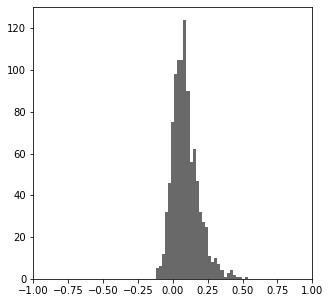

synonymity
average:  0.41011743545997886


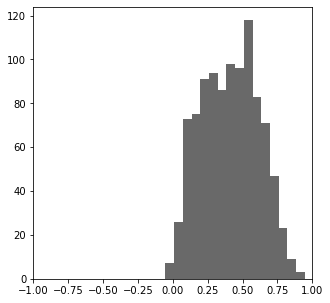

hypernymy
average:  0.16010629918565975


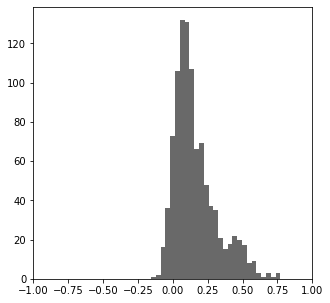

hyponymy
average:  0.326046823575045


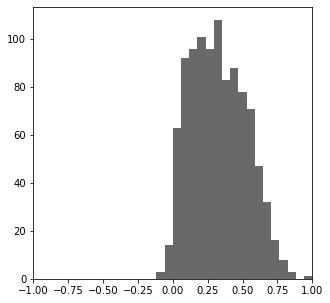

direct-hypernymy
average:  0.3319179073526757


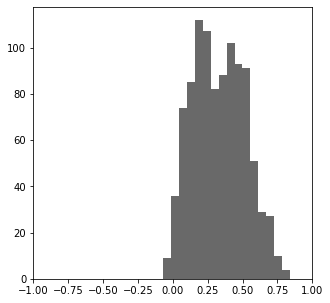

direct-hyponymy
average:  0.32929708919266704


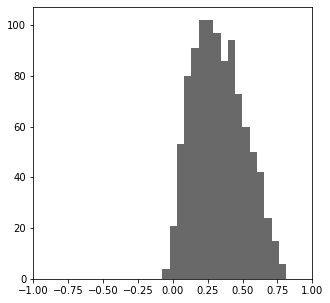

In [ ]:
relations = ['random', 'synonymity', 'hypernymy', 'hyponymy', 'direct-hypernymy', 'direct-hyponymy']
plot_size = (5, 5)

model = noun2vec
similarity_measure = 'cosine_similarity'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=1000)
    plt.figure(figsize=plot_size)
    plt.xlim(-1, 1)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.hist(sample, bins='auto', facecolor='dimgray')
    plt.show()


### Word2Vec, euclidean distance

random
average:  4.3601216096878055


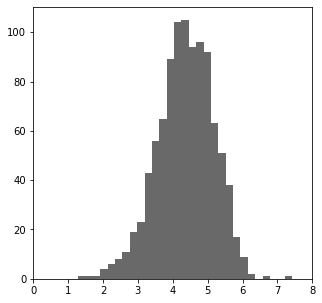

synonymity
average:  3.3978499634861947


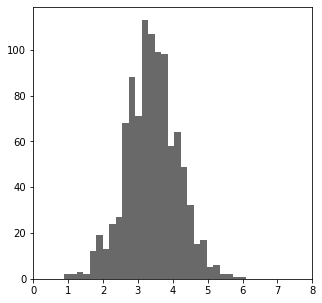

hypernymy
average:  3.95197693002224


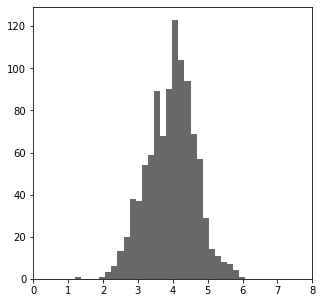

hyponymy
average:  3.790228697359562


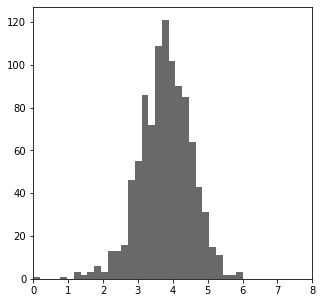

direct-hypernymy
average:  3.720200508594513


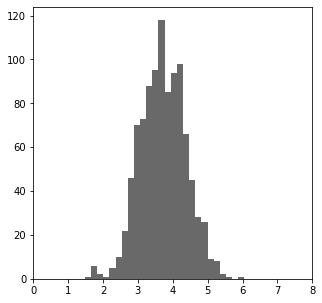

direct-hyponymy
average:  3.7441123365163804


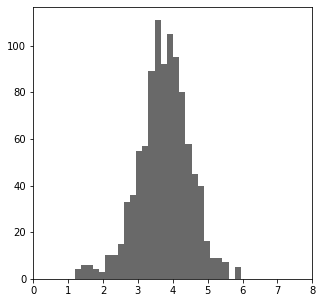

In [ ]:
model = noun2vec
similarity_measure = 'euclidean'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=1000)
    plt.figure(figsize=plot_size)
    plt.xlim(0, 8)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.hist(sample, bins='auto', facecolor='dimgray')
    plt.show()


### GloVe, cosine similarity

random
average:  0.04202953089819758


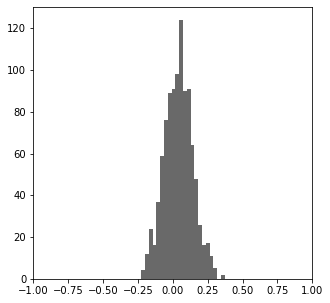

synonymity
average:  0.2765477565513295


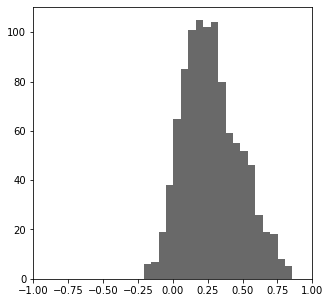

hypernymy
average:  0.03466921888792273


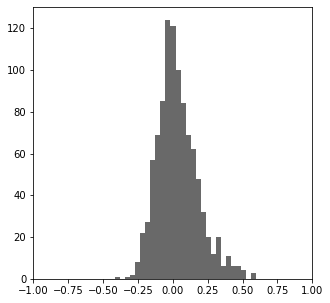

hyponymy
average:  0.19553927425371267


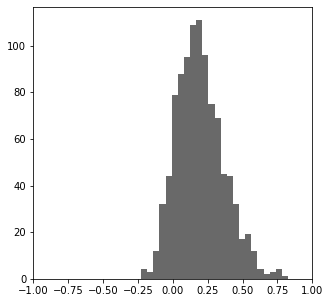

direct-hypernymy
average:  0.19264189509221466


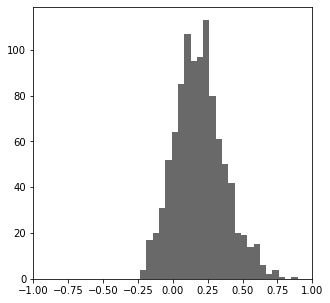

direct-hyponymy
average:  0.20591517537565573


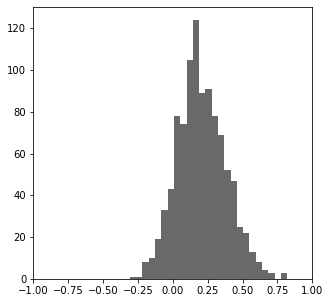

In [ ]:
model = noun_glove
similarity_measure = 'cosine_similarity'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=1000)
    plt.figure(figsize=plot_size)
    plt.xlim(-1, 1)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.hist(sample, bins='auto', facecolor='dimgray')
    plt.show()


### GloVe, euclidean distance

random
average:  9.079367521365889


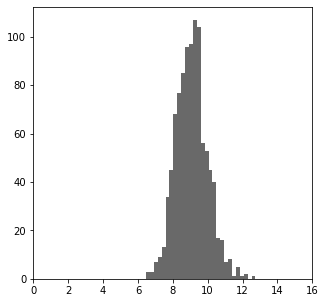

synonymity
average:  7.645800058018993


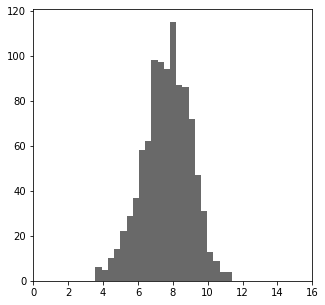

hypernymy
average:  8.817931778831152


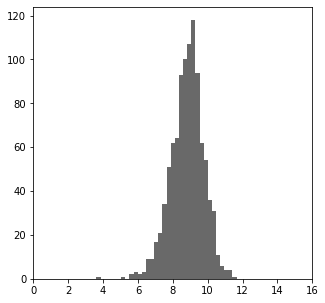

hyponymy
average:  8.15123166430834


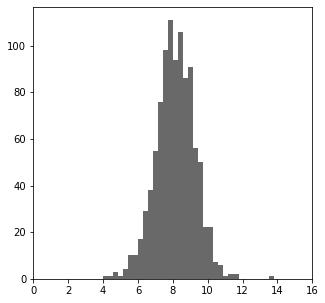

direct-hypernymy
average:  8.249720358130139


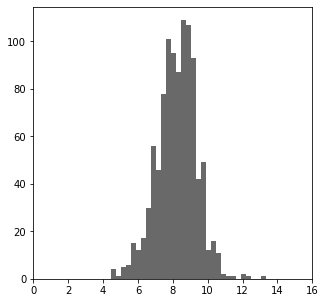

direct-hyponymy
average:  8.128778679697666


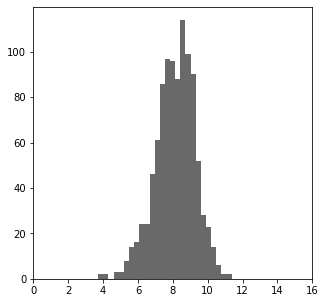

In [ ]:
model = noun_glove
similarity_measure = 'euclidean'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=1000)
    plt.figure(figsize=plot_size)
    plt.xlim(0, 16)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.hist(sample, bins='auto', facecolor='dimgray')
    plt.show()




### Lin similarity

random
average:  0.021162750558289607


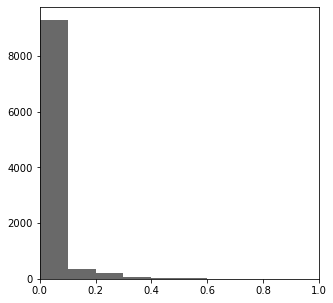

synonymity
average:  1.0


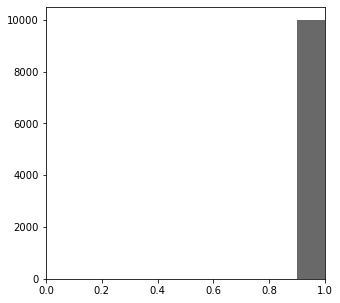

hypernymy
average:  0.1891758053440921


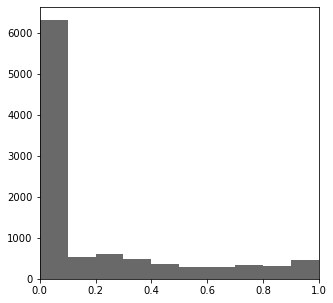

hyponymy
average:  0.48721912812077856


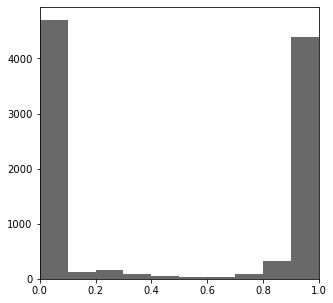

direct-hypernymy
average:  0.5200269656940794


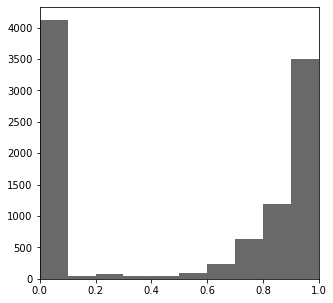

direct-hyponymy
average:  0.5245966860802492


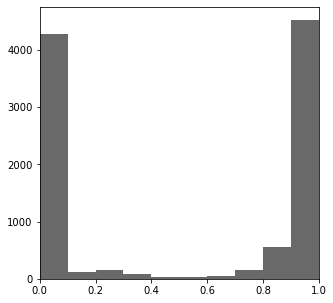

In [ ]:
model = noun_glove  # The choice of model is arbitrary here, since the Lin similarity does not depend on it.
similarity_measure = 'lin_similarity'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=10000)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.figure(figsize=plot_size)
    plt.xlim(0, 1)
    plt.hist(sample, bins=np.arange(0, 1.1, .1), facecolor='dimgray')
    plt.show()


### Leacock-Chodorow Similarity

random
average:  0.3070812619127845


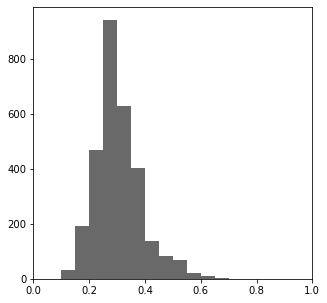

synonymity
average:  1.0


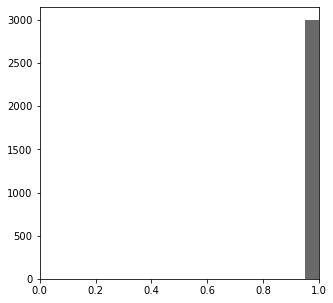

hypernymy
average:  0.538184618714345


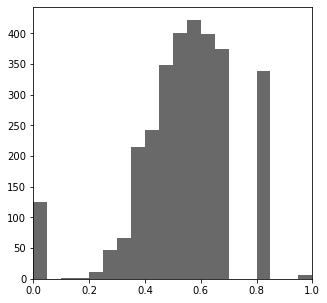

hyponymy
average:  0.7272295951065739


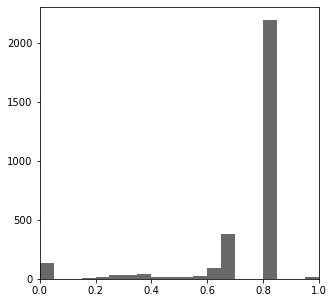

direct-hypernymy
average:  0.8106554131851996


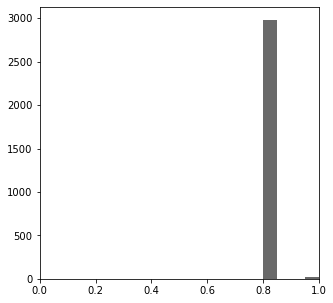

direct-hyponymy
average:  0.8104013446352971


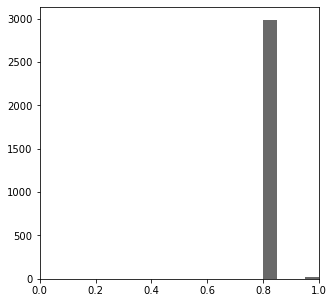

In [ ]:
model = noun_glove  # The choice of model is arbitrary here, since L.-Ch. similarity does not depend on it.
similarity_measure = 'lch_similarity'

for rel in relations:

    sample = model.sample_similarity(relation=rel, similarity_measure=similarity_measure, n_samples=3000)
    print(rel)
    print('average: ', sum(sample)/len(sample))
    plt.figure(figsize=plot_size)
    plt.xlim(0, 1)
    plt.hist(sample, bins=np.arange(0, 1.05, 0.05), facecolor='dimgray')
    plt.show()

## Correlation between graph-induced and vector-based similarity measures

In [ ]:
cor = noun2vec.correlate_similarity(n_samples=1000, threshold=0)

import pprint
pprint.pprint(cor)


{('cosine_similarity', 'cosine_similarity'): SpearmanrResult(correlation=1.0, pvalue=0.0),
 ('cosine_similarity', 'euclidean'): SpearmanrResult(correlation=-0.01654819654819655, pvalue=0.6011961161350545),
 ('cosine_similarity', 'lch_similarity'): SpearmanrResult(correlation=-0.03313558961077088, pvalue=0.29518433265549554),
 ('cosine_similarity', 'lin_similarity'): SpearmanrResult(correlation=0.05214945229942599, pvalue=0.09931790082361326),
 ('euclidean', 'cosine_similarity'): SpearmanrResult(correlation=-0.01654819654819655, pvalue=0.6011961161350545),
 ('euclidean', 'euclidean'): SpearmanrResult(correlation=1.0, pvalue=0.0),
 ('euclidean', 'lch_similarity'): SpearmanrResult(correlation=-0.06701469505827388, pvalue=0.03409701334743419),
 ('euclidean', 'lin_similarity'): SpearmanrResult(correlation=-0.00873034956557481, pvalue=0.7827494200452205),
 ('lch_similarity', 'cosine_similarity'): SpearmanrResult(correlation=-0.03313558961077088, pvalue=0.29518433265549554),
 ('lch_similarity

Maybe the lack of correlation is due to the fact that most words are mostly unrelated, and the similarity measures' behaviour on unrelated is arbitrary. To falsify this, we set the threshold to 0.7. Computation might take a little while...

In [ ]:
cor = noun2vec.correlate_similarity(n_samples=100, threshold=.7)
pprint.pprint(cor)


{('cosine_similarity', 'cosine_similarity'): SpearmanrResult(correlation=1.0, pvalue=0.0),
 ('cosine_similarity', 'euclidean'): SpearmanrResult(correlation=0.07471969612903756, pvalue=0.4600062621367198),
 ('cosine_similarity', 'lch_similarity'): SpearmanrResult(correlation=0.09450843864685195, pvalue=0.34963477961774936),
 ('cosine_similarity', 'lin_similarity'): SpearmanrResult(correlation=-0.21120165262563007, pvalue=0.034917058595245305),
 ('euclidean', 'cosine_similarity'): SpearmanrResult(correlation=0.07471969612903756, pvalue=0.4600062621367198),
 ('euclidean', 'euclidean'): SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0),
 ('euclidean', 'lch_similarity'): SpearmanrResult(correlation=0.11646788131912697, pvalue=0.2485132796525942),
 ('euclidean', 'lin_similarity'): SpearmanrResult(correlation=-0.19941567078849123, pvalue=0.04668890514604335),
 ('lch_similarity', 'cosine_similarity'): SpearmanrResult(correlation=0.09450843864685195, pvalue=0.34963477961774936),
 ('lc

### Side note: A Caveat of WordNet's hyponymity relation:

It's not a partial order on synsets! In other words, the directed graph with vertices given by synsets and edges given by hyponymity contains cycles:

In [ ]:
restr = wordnet.synsets('restrain')[0]

print("synsets of \'restrain.v.01\':")
print(restr.hyponyms())
print("synsets of \'inhibit.v.04\':")
print(restr.hyponyms()[3].hyponyms())

# This won't work:
# hyponyms = list(set([w for s in wordnet.synsets(restr)[0].closure(lambda s: s.hyponyms()) for w in s.lemma_names()]))

synsets of 'restrain.v.01':
[Synset('confine.v.03'), Synset('control.v.02'), Synset('hold.v.36'), Synset('inhibit.v.04')]
synsets of 'inhibit.v.04':
[Synset('choke.v.07'), Synset('quench.v.03'), Synset('restrain.v.01')]


## Antonyms via Analogies

#### How many antonyms we can find using the scheme _adjective_ - 'good' + 'bad' ≈ _antonym_ ?

In [ ]:
def get_all_antonyms(word):
    # Each lemma in each synset of an adjective has a set of antonyms;
    # we collect them all together.

    antonyms = []
    synsets = wordnet.synsets(word, 'a')

    for synset in synsets:

        for lemma in synset.lemmas():

            for antonym in lemma.antonyms():

                antonyms.append(antonym.name())

    return antonyms


has_antonyms = lambda adj: (get_all_antonyms(adj) != [])
adjectives_with_antonyms = [a for a in adjective2vec.words() if has_antonyms(a)]

print(len(adjectives_with_antonyms))  # 3341 adjectives with antonyms in total.

3341


In [ ]:
get_all_antonyms('abstract')  # example

['concrete']

In [ ]:
def get_positively_connotated(print_hits=True):
    # Collect all 'positively connotated' adjectives for which the
    # adjective - 'good' + 'bad' scheme works.

    positively_connotated = []

    for word in adjectives_with_antonyms:

        candidate_antonyms = word2vec_model.most_similar(positive=['bad', word], negative=['good'])
        candidate_antonyms = [candidate_antonym[0] for candidate_antonym in candidate_antonyms]
        hit = False
        antonyms = get_all_antonyms(word)

        for candidate_antonym in candidate_antonyms:

            if candidate_antonym in antonyms:

                hit = True

        if hit == True:

            positively_connotated.append(word)

            if print_hits == True: print(word)

    return positively_connotated


**Warning:** The subsequent cell might take a long time to execute...

In [ ]:
positively_connotated = get_positively_connotated()

implicit
appealing
loving
meaningful
proportionate
infallible
outward
legible
unburdened
hypotonic
orthodox
contralateral
early
downtown
brunette
maximum
opening
hydrophobic
unconventional
increasing
courteous
unclassified
inside
frequent
first
wifely
trained
unabridged
civilian
responsive
livable
tolerable
adequate
lengthwise
unintrusive
major
more
conclusive
accurate
skilled
equal
ipsilateral
starry
courageous
anterior
alkaline
uptown
publishable
tractable
private
brave
eligible
careful
intelligent
abridged
outboard
aware
dissimilar
abundant
acidic
same
bridgeable
finite
noble
beneficent
unlucky
fair
western
discreet
unnoticeable
unrelated
symmetrical
monotheistic
inward
felicitous
occupied
ethical
less
unprofitable
rational
consistent
lively
intelligible
southern
auspicious
asymmetrical
operational
crossbred
quadrupedal
descending
enfranchised
frozen
eventful
matched
inner
comprehensible
farsighted
fruitful
unmodified
fastened
strong
second
undrinkable
hot
outdoor
knowable
sociable


In [ ]:
positively_connotated_with_antonyms = set(positively_connotated + flatten_list([get_all_antonyms(a) for a in pos_con]))
print(len(positively_connotated_with_antonyms))

693


##### Hence we see that this works for 639 adjectives. The name 'positively connotated' is appropriate only to a very limited extend, however.

#### Can we achieve similar results with pairs other than 'good' and 'bad'?

In [ ]:
def get_small_connotated(print_hits=True):
    # Collect all adjectives for which a "adjective - 'big' + 'small'" scheme works.

    small_connotated = []

    for word in adjectives_with_antonyms:

        candidate_antonyms = word2vec_model.most_similar(positive=['small', word], negative=['big'])
        candidate_antonyms = [candidate_antonym[0] for candidate_antonym in candidate_antonyms]
        hit = False
        antonyms = get_all_antonyms(word)

        for candidate_antonym in candidate_antonyms:

            if candidate_antonym in antonyms:

                hit = True

        if hit == True:

            small_connotated.append(word)

            if print_hits == True: print(word)

    return small_connotated


**Warning:** The subsequent cell might take a long time to execute...

In [ ]:
small_connotated = get_small_connotated()

implicit
incurable
proportionate
infallible
outward
legible
unburdened
hypotonic
contralateral
early
downtown
brunette
maximum
unseaworthy
inopportune
opening
hydrophobic
unconventional
increasing
unclassified
inside
frequent
first
wifely
trained
unabridged
civilian
radiopaque
livable
organized
adequate
explosive
lengthwise
major
more
conclusive
unadvisable
accurate
bad
postwar
skilled
equal
ipsilateral
impaired
unenthusiastic
alkaline
uptown
dystopian
private
eligible
unpolished
unfriendly
unrefined
abridged
outboard
aware
undesirable
dissimilar
acidic
same
bridgeable
finite
unadoptable
unlucky
insufficient
western
noncompliant
unrelated
indelicate
symmetrical
monotheistic
migratory
inward
occupied
ethical
less
cationic
unprofitable
rational
consistent
perinatal
southern
auspicious
asymmetrical
crossbred
descending
enfranchised
frozen
eventful
inner
fruitful
unmodified
strong
blond
second
undrinkable
tuneless
outdoor
knowable
inappropriate
wrinkly
refined
polished
convex
logical
willi

In [ ]:
small_connotated_with_antonyms = set(small_connotated + flatten_list([get_all_antonyms(a) for a in pos_con]))
print(len(small_connotated_with_antonyms))
print(len(set(list(small_connotated_with_antonyms) + list(positively_connotated_with_antonyms))))

651
907


#### So taking together the examples from before, we are able to collect some antonyms this way, but extremely significantly so. Moreover, most of these do not seem to satisfy a proportional analogy involving 'small' and 'big', which was our initial hypothesis on why this should even work. Therefore, some doubts have to remain about the significance of these results...

### The phenomena reported above may even just be due to the fact that an adjective has fairly high cosine similarity to its antonym, on average, and so shifting it by, say, 'bad'-'good' will leave the antonym nearby:

average:  0.4132209293840482


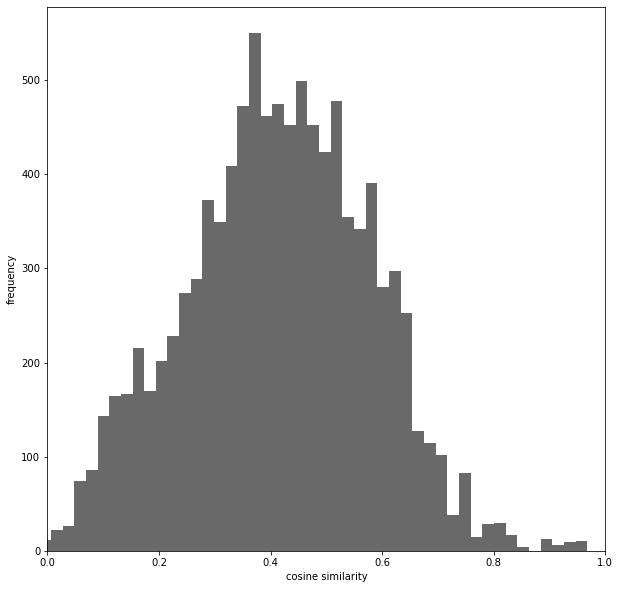

In [ ]:
def sample_antonym_similarity(n_samples=10000):

    sim_sample = []
    i = 0

    while i < n_samples:

        try:

            adj = random.choice(adjectives_with_antonyms)
            sim_sample.append(adjective2vec.cos_sim(random.choice(get_all_antonyms(adj)), adj))
            i += 1

        except KeyError: pass

    return np.array(sim_sample)

plot_size = (10, 10)
sample = sample_antonym_similarity()
print('average: ', sum(sample)/len(sample))
plt.figure(figsize=plot_size)
plt.xlim(0, 1)
plt.xlabel('cosine similarity')
plt.ylabel('frequency')
plt.hist(sample, facecolor='dimgray', bins='auto')
plt.show()

### To further test this, let's see how many andjectives have a nearby antonym.

In [ ]:
def get_adj_with_close_ant(print_hits=True):
    # Collect all 'positively connotated' adjectives for which the
    # adjective - 'good' + 'bad' scheme works.

    adj_with_close_ant = []

    for word in adjectives_with_antonyms:

        candidate_antonyms = word2vec_model.most_similar(positive=[word])
        candidate_antonyms = [candidate_antonym[0] for candidate_antonym in candidate_antonyms]
        hit = False
        antonyms = get_all_antonyms(word)

        for candidate_antonym in candidate_antonyms:

            if candidate_antonym in antonyms:

                hit = True

        if hit == True:

            adj_with_close_ant.append(word)

            if print_hits == True: print(word)

    return adj_with_close_ant


In [ ]:
# Our 'test adejectives', 'good' and 'bad' are quite cosine-similar themselves.
adjective2vec.cos_sim('good', 'bad')

0.7190051

In [ ]:
adjs_with_close_ant = get_adj_with_close_ant()

haploid
illegible
invertebrate
wide
highland
representational
brunette
attachable
noncompetitive
dispensable
civilian
mature
inhumane
unequal
deflationary
ventral
digestible
eccrine
tactful
unclassified
defensive
pleasant
infallible
honorable
offstage
excusable
elective
biennial
unqualified
related
unpublished
conservative
diurnal
comfortable
enclosed
anabolic
unpeaceful
omnivorous
encouraging
intrastate
unfruitful
undefined
seasoned
extrinsic
unsatisfactory
parallel
inclined
worst
fatal
decreased
unprofitable
heterogeneous
insincere
hospitable
reduced
downmarket
incoming
homozygous
fallible
unconfined
plus
moonless
first
inbred
enfranchised
unmodified
passable
harmless
external
more
anterior
de_jure
incompatible
scarce
incompressible
unambiguous
censored
open
same
perinatal
admissible
inhospitable
imprecise
cool
testate
western
husbandly
inferior
equivocal
unbreakable
unafraid
convenient
anisotropic
lawful
horned
unorthodox
explicit
grassless
female
early
increased
favorable
involunta

fast
easy
nonconformist
satisfactory
interdepartmental


In [ ]:
print(len(adjs_with_close_ant))

826


### Hence, our initial hypothesis that antonymy is related to analogy-solving in the Word Embedding is very likely false. However, we have found an alternative 'stupid' way of finding likely antonyms: just look at adjectives that are nearby!